In [107]:
from shapely.geometry import Point, LineString, shape, MultiPoint
from shapely.ops import nearest_points
import numpy as np
import geojson
import folium
from pyproj import Transformer

In [ ]:
shape()

In [68]:
with open("/Users/dhirst/PycharmProjects/pretadata/prets.geojson") as f:
    prets = geojson.load(f)

prets = list(map(lambda x: transformer.transform(*x.coords[0]), MultiPoint([g.geometry.coordinates for g in prets.features])))
prets

/var/folders/pq/7y67wfk129gg77clnzwmtmg0twzrrz/T/ipykernel_31297/2976717971.py:4: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  prets = list(map(lambda x: transformer.transform(*x.coords[0]), MultiPoint([g.geometry.coordinates for g in prets.features])))


[(4537242.182175431, -12506938.033447001),
 (4532181.820762951, -12519483.633060584),
 (4537068.857728265, -12505320.439453976),
 (4536124.97976583, -12511207.535837105),
 (4330582.8908532765, -13870643.34144436),
 (4536447.361011168, -12512476.569942623),
 (4328845.750199447, -13855032.39818338),
 (4330708.793197364, -13875360.107853692),
 (4535352.756458198, -12511823.455285178),
 (4447528.580030733, -13018177.274466088),
 (4329879.796949427, -13868621.989172146),
 (4536057.965432373, -12512757.53397099),
 (4537388.01070837, -12504381.359236965),
 (4531282.3592773415, -12520316.943569602),
 (4535196.797851596, -12509879.42705781),
 (4536536.639242783, -12511164.350969499),
 (4447540.491216248, -13018155.48739459),
 (4534863.729935142, -12511732.234250505),
 (4447852.519748942, -13010990.138097648),
 (4330920.188910381, -13874883.0159976),
 (4536887.184319291, -12512037.789288223),
 (4536474.189008448, -12507456.343802013),
 (4531467.706229512, -12519465.448498627),
 (4537631.13247626

In [39]:
prets.keys()

dict_keys(['type', 'features'])

In [88]:
with open("/Users/dhirst/PycharmProjects/pretadata/prets.geojson") as f:
    prets = geojson.load(f)
list(map(lambda x: transformer.transform(*x), [g.geometry.coordinates for g in prets.features]))

[(4537242.182175431, -12506938.033447001),
 (4532181.820762951, -12519483.633060584),
 (4537068.857728265, -12505320.439453976),
 (4536124.97976583, -12511207.535837105),
 (4330582.8908532765, -13870643.34144436),
 (4536447.361011168, -12512476.569942623),
 (4328845.750199447, -13855032.39818338),
 (4330708.793197364, -13875360.107853692),
 (4535352.756458198, -12511823.455285178),
 (4447528.580030733, -13018177.274466088),
 (4329879.796949427, -13868621.989172146),
 (4536057.965432373, -12512757.53397099),
 (4537388.01070837, -12504381.359236965),
 (4531282.3592773415, -12520316.943569602),
 (4535196.797851596, -12509879.42705781),
 (4536536.639242783, -12511164.350969499),
 (4447540.491216248, -13018155.48739459),
 (4534863.729935142, -12511732.234250505),
 (4447852.519748942, -13010990.138097648),
 (4330920.188910381, -13874883.0159976),
 (4536887.184319291, -12512037.789288223),
 (4536474.189008448, -12507456.343802013),
 (4531467.706229512, -12519465.448498627),
 (4537631.13247626

In [204]:
# Kensington Palace
start_point = (-0.08141040802001953, 51.51831709687373)
# London Transport Museum
end_point = (-0.12252330780029295, 51.51205441622754)
n = 5

DISTANCE_THRESH = 2500

transformer = Transformer.from_crs(4326, 3857)
transformer_back = Transformer.from_crs(3857, 4326)
with open("/Users/dhirst/PycharmProjects/pretadata/prets.geojson") as f:
    prets = geojson.load(f)


prets_4326 = prets
prets_4326_list = [tuple(g.geometry.coordinates) for g in prets.features]


def distance(point, points_array):
    return np.sqrt(np.sum((points_array - point) ** 2, 1))


prets_list = list(map(lambda x: transformer.transform(*x), [g.geometry.coordinates for g in prets.features]))
prets = MultiPoint(prets_list)
print(prets_list)

def run_pret_crawl(start_point, end_point, n=5):
    start_point = np.array(transformer.transform(*start_point))
    end_point = np.array(transformer.transform(*end_point))

    route = LineString((start_point, end_point))
    buffered_route = route.buffer(500)

    filtered_prets = np.array([np.array((geom.xy[0][0], geom.xy[1][0])) for geom in filter(lambda x: buffered_route.contains(x),prets)])

    start_distances = distance(start_point, filtered_prets)
    first_pret = filtered_prets[np.argmin(np.abs(start_distances - DISTANCE_THRESH))]

    current_pret = first_pret

    pret_crawl = [start_point, current_pret]

    while distance(current_pret, [end_point])[0] >= DISTANCE_THRESH:
        distance_array = distance(current_pret, filtered_prets)
        next_pret = filtered_prets[np.argmin(np.abs(distance_array - DISTANCE_THRESH))]
        pret_crawl.append(next_pret)
        current_pret = next_pret

        relevant_indices = np.where(start_distances > distance(current_pret, [start_point])[0])[0]
        filtered_prets = np.take(filtered_prets, relevant_indices, axis=0)
        start_distances = np.take(start_distances, relevant_indices)
        print(f"distance to end point: {distance(current_pret, [end_point])[0]}")

    pret_crawl.append(end_point)

    pc = [start_point]
    for pret in pret_crawl[1:-1]:
        pc.append(prets_4326_list[np.where(pret == np.array(prets_list))[0][0]])

    pc.append(end_point)


    return pc





    # pc.append(prets_list[np.where(np.array(pret) == np.array(prets_list))[0]])

pc.append(end_point)
pc

[(4537242.182175431, -12506938.033447001), (4532181.820762951, -12519483.633060584), (4537068.857728265, -12505320.439453976), (4536124.97976583, -12511207.535837105), (4330582.8908532765, -13870643.34144436), (4536447.361011168, -12512476.569942623), (4328845.750199447, -13855032.39818338), (4330708.793197364, -13875360.107853692), (4535352.756458198, -12511823.455285178), (4447528.580030733, -13018177.274466088), (4329879.796949427, -13868621.989172146), (4536057.965432373, -12512757.53397099), (4537388.01070837, -12504381.359236965), (4531282.3592773415, -12520316.943569602), (4535196.797851596, -12509879.42705781), (4536536.639242783, -12511164.350969499), (4447540.491216248, -13018155.48739459), (4534863.729935142, -12511732.234250505), (4447852.519748942, -13010990.138097648), (4330920.188910381, -13874883.0159976), (4536887.184319291, -12512037.789288223), (4536474.189008448, -12507456.343802013), (4531467.706229512, -12519465.448498627), (4537631.132476263, -12510207.091304805)

/var/folders/pq/7y67wfk129gg77clnzwmtmg0twzrrz/T/ipykernel_31297/2257594571.py:34: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  filtered_prets = np.array([np.array((geom.xy[0][0], geom.xy[1][0])) for geom in filter(lambda x: buffered_route.contains(x),prets)])


[(-0.08141040802001953, 51.51831709687373),
 (-0.103742, 51.516676),
 (-0.12252330780029295, 51.51205441622754)]

In [99]:
Point(transformer.transform(*start_point)).xy

(array('d', [5734992.825750384]), array('d', [-9062.568215463409]))

In [65]:
list(MultiPoint([g.geometry.coordinates for g in prets.features])[0].coords)[0]


/var/folders/pq/7y67wfk129gg77clnzwmtmg0twzrrz/T/ipykernel_31297/1353630911.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list(MultiPoint([g.geometry.coordinates for g in prets.features])[0].coords)[0]


(-73.978674, 40.75874)

In [66]:
buffered_route = route.buffer(0.01)
list(map(lambda x: transformer.transform(*x.coords[0]), filter(lambda x: buffered_route.contains(x),MultiPoint([g.geometry.coordinates for g in prets.features]))))


/var/folders/pq/7y67wfk129gg77clnzwmtmg0twzrrz/T/ipykernel_31297/1444229926.py:2: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list(map(lambda x: transformer.transform(*x.coords[0]), filter(lambda x: buffered_route.contains(x),MultiPoint([g.geometry.coordinates for g in prets.features]))))


[(5734466.162455506, -11573.337211241005),
 (5734345.714766468, -12756.331593272156),
 (5734849.76942078, -14158.848982540969),
 (5734299.5171777895, -9133.54470221847),
 (5735310.8547516465, -8832.313861347384),
 (5734922.68368725, -13489.14935262027),
 (5734687.242964221, -14525.091033207864),
 (5734610.543835064, -11040.449971315064),
 (5734714.850197938, -12471.241819814859),
 (5734294.2851617215, -10861.55928592426),
 (5733602.991123895, -12982.97853792609),
 (5734886.059574778, -9185.196999206899),
 (5735184.841088067, -11345.46584578891),
 (5734868.582414724, -10801.335354564062),
 (5735616.092795401, -8625.370734156952),
 (5734289.498423618, -10299.951681924502),
 (5734947.730572678, -8878.066216158704),
 (5734548.984156657, -11918.650857288758),
 (5734863.573037638, -10389.341350603305),
 (5733753.940353411, -14164.748930096428),
 (5734649.839615315, -9226.051294880705),
 (5734731.102843594, -12177.357815461395),
 (5734603.085429182, -10369.415135366773),
 (5735449.5588371735,

In [48]:
route.buffer(0.01).contains(MultiPoint([g.geometry.coordinates for g in prets.features]))

False

In [4]:
prets = gpd.read_file("https://raw.githubusercontent.com/Jonty/pretadata/master/prets.geojson")
prets.explore()

In [24]:
prets[prets.within(route.buffer(0.1))]

,name,geometry
115,"Oxford Street, Rathbone Place",POINT (-0.13308 51.51683)
116,"Vauxhall Bridge Road, 40",POINT (-0.13261 51.49032)
118,New Bridge Street,POINT (-0.10396 51.51359)
119,"Oxford St, West One",POINT (-0.14925 51.51392)
122,St Christopher's Place,POINT (-0.15002 51.51503)
...,...,...
581,"Piccadilly, 81",POINT (-0.14351 51.50665)
582,Tavistock Square,POINT (-0.12843 51.52542)
583,"Baker Street, 211-213",POINT (-0.15809 51.52296)
584,London Wall,POINT (-0.08805 51.51733)


In [ ]:
geojson.load()

In [11]:
# Kensington Palace
start_point = (-0.08141040802001953, 51.51831709687373)
# London Transport Museum
end_point = (-0.12252330780029295, 51.51205441622754)
n = 5

In [17]:
def make_pret_crawl(start_point: Point, end_point: Point, num_prets=5) -> LineString:
    return (start_point[::-1], end_point[::-1])

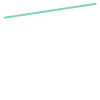

In [20]:
route = LineString([start_point, end_point])
route

In [145]:
run_pret_crawl(start_point, end_point)

distance to end point: 4680.344272655694
distance to end point: 3704.816410459484
distance to end point: 2777.683687757187
distance to end point: 1739.1392878021359
distance to end point: 884.328357757728


/var/folders/pq/7y67wfk129gg77clnzwmtmg0twzrrz/T/ipykernel_31297/2038850440.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  filtered_prets = np.array([np.array((geom.xy[0][0], geom.xy[1][0])) for geom in filter(lambda x: buffered_route.contains(x),prets)])


[(45.716242022815514, -0.08141043541326556),
 (45.71705955588801, -0.08976803672555768),
 (45.715286792483695, -0.08076502674689007),
 (45.7149174306029, -0.08953003643422226),
 (45.71186050076289, -0.09757104715916078),
 (45.71345811309566, -0.10706706231186727),
 (45.71218309924067, -0.11459207639533105),
 (45.71186917060565, -0.12252340118163703)]

In [205]:
pc_switched = [[x[1], x[0]] for x in pc]
pc_switched

[[51.51831709687373, -0.08141040802001953],
 [51.516676, -0.103742],
 [51.51205441622754, -0.12252330780029295]]

In [206]:
m = folium.Map(location=start_point[::-1], zoom_start=13)
my_PolyLine=folium.PolyLine(locations=pc_switched,weight=5)
m.add_child(my_PolyLine)

In [ ]:
def run_pret